[ 1.4761707   0.67408422 -0.86005157 -0.98418883]
[1.76399623e-17 1.03122694e+01 1.71127693e-15 1.51441764e-15]


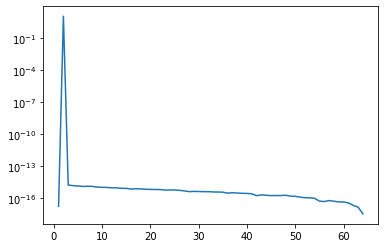

In [114]:
import numpy as np
import numpy.random as rand
import numpy.linalg as linalg
import matplotlib.pyplot as plt

# SNR is a range between min and max SNR in dB
def generate_signal(N = 16, K = 4, L = 16, f = 2.4e9, theta_bound = np.pi/2):
    c = 3e8 # speed of light
    wl = c/f # wavelength (lambda)
    d = wl/2 # uniform distance between antennas
        
    # antenna array
    array = np.linspace(0,N-1,N)*d/wl

    theta = rand.rand(K,1) * np.pi - np.pi/2

    
    alpha = (np.random.randn(K,1) + 1j*np.random.randn(K,1))*np.sqrt(1/2)
        
    response = np.exp(-1j*2*np.pi*array*np.sin(theta))*np.sqrt(1/N)    
                
    Y = np.dot(response.T, alpha).repeat(L, axis=1)

                
    return theta, Y, alpha

N = 64
K = 4
T = 32

theta, X_raw, alpha = generate_signal(N, K, T)

Noise = (np.random.randn(N, T) + 1j*np.random.randn(N, T))*np.sqrt(1/1000)

X = X_raw + Noise

C = np.dot(X_raw, X_raw.T.conj())/T

eig = linalg.eig(C)[0]

theta = np.sort(theta.flatten())[::-1]

print(theta)
plt.semilogy(list(range(1,N+1)), np.abs(eig))
print(np.abs(eig)[:K])

In [ ]:
def compute_H(theta, f = 2.4e9):
    c = 3e8 # speed of light
    wl = c/f # wavelength (lambda)
    d = wl/2 # uniform distance between antennas
    array = np.linspace(0,N-1,N)*d/wl
    
    array_response = np.exp(-1j*2*np.pi*array*np.sin(theta))*np.sqrt(1/N)  
    return array_response.T

search_space_len = 1800 + 1
search_space = np.linspace(0,search_space_len-1, search_space_len) / search_space_len * np.pi - np.pi/2
search_space = search_space.reshape((search_space_len, 1))

A = compute_H(search_space)

A_r = A.real
A_c = A.imag

A_top = np.concatenate((A_r, -A_c), axis=1)
A_bot = np.concatenate((A_c, A_r), axis=1)

A_total = np.concatenate((A_top, A_bot), axis=0)

b = np.concatenate((X.real, X.imag), axis=0)

l = 0.5  # regularization parameter


def soft_thresh(x, l):
    return np.sign(x) * np.maximum(np.abs(x) - l, 0.)


def ista(A, b, thresh, l, maxit):
    x = np.zeros((2*search_space_len, T))
    L = linalg.norm(A) ** 2
    for _ in range(maxit):
        x = thresh(x + np.dot(A.T, b - A.dot(x)) / L, l / L)
        
    return x

maxit = 3000

x_ista = ista(A_total, b, soft_thresh, l, maxit)

x_ista_r, x_ista_c = np.array_split(x_ista, 2, axis=0)
x_ista = x_ista_r + 1j*x_ista_c
x_ista = np.mean(x_ista, axis=1)

vector_to_rads = lambda x: x/(search_space_len) * np.pi - np.pi/2

idx = np.argwhere(np.abs(x_ista) > 0)

theta_hat = np.sort(vector_to_rads(idx).flatten())[::-1]

alpha_actual = np.zeros((search_space_len))
alpha_hat = np.zeros((search_space_len))

theta_idx = (np.floor((theta+np.pi/2)/np.pi * search_space_len)).astype(int)
theta_hat_idx = (np.floor((theta_hat+np.pi/2)/np.pi * search_space_len)).astype(int)

alpha_actual[theta_idx] = np.abs(alpha[0,:].T)
alpha_hat[theta_hat_idx] = np.abs(x_ista[theta_hat_idx]) / np.max(np.abs(x_ista[theta_hat_idx]))

plt.figure(figsize=(15, 8))
plt.plot(search_space, alpha_actual)
plt.plot(search_space, alpha_hat)
plt.xlabel('Angle (radians)')
plt.ylabel('Amplitude')
plt.legend(['Actual signal', 'Estimated signal'])

theta_soft = theta_hat

In [52]:
x_ista

array([-0.00033979+0.j, -0.00033673+0.j, -0.00032742+0.j, ...,
       -0.00036636+0.j, -0.00035181+0.j, -0.00034283+0.j])